In [1]:
using LinearAlgebra
using PolyChaos
using QuadGK
using Plots

In [2]:
function create_spectral(input::AbstractString, D::Float64, g::Float64) # (bool, amp, mean, sd)
        # window
        inband = x -> (-D <= x <= D)
        
        if input == "flat"
            J = x -> inband(x) ? 1.0 : 0.0
        elseif input == "elliptical"
            J = x -> inband(x) ? sqrt(1 - (x/D)^2) : 0.0
        elseif input == "ohmic"
            J = x -> inband(x) ? abs(x) : 0.0
        elseif input == "lorentzian"
            J = x -> 1/(1 + (x/D)^2)
        else
            error("spectral function type not recognized")
        end
        # normalization
        norm = quadgk(J, -D, D)[1]           
        Jnorm = x -> g*D/pi * J(x) / norm
        return Jnorm
    end

function modify_spectral(J::Function, input::AbstractString, params::Tuple, g::Float64, D::Float64)
    """modifies the spectral function by adding a feature such as a band gap or gaussian perturbation"""
    inband = x -> (-D <= x <= D)
    
    if input == "gaussian"
        avg, std, amp = params
        Jmod = x -> inband(x) ? J(x) + amp*exp(-((x-avg)^2)/(std^2)) : 0.0
        norm = quadgk(Jmod, -D, D)[1]           
        Jnorm = x -> g*D/pi * Jmod(x) / norm
        return Jmod

    elseif input == "bandgap"
        width, centre, _ = params #width of gap, centre of gap
        inband1 = x -> (-D <= x <= centre-width/2 )
        inband2 = x -> (centre+width/2 <= x <= D)
        J1 = x -> inband1(x) ? J(x) : 0.0
        J2 = x -> inband2(x) ? J(x) : 0.0
        norm = quadgk(J1, -D, D)[1]           
        Jnorm1 = x -> g*D/pi * J1(x) / norm
        norm = quadgk(J2, -D, D)[1] 
        Jnorm2 = x -> g*D/pi * J2(x) / norm
        return Jnorm1, Jnorm2 #returns spectral functions for left and right of band gap
    else
        println("invalid modification")
    end     
end

function thermofield_transform(J, beta::Float64, mu::Float64) #spectral function, inverse temp, chemical potential
    """thermofield purification using fermi function ancilla"""
    fermi(k) = 1/(1 + exp(beta*k - beta*mu))
    J1 = w -> J(w) * fermi(w) #filled mode spectral density
    J2 = w -> J(w) * (1 - fermi(w)) #empty mode spectral density
    return J1, J2
end

function chain_map(J, N::Int64, D::Float64)
    """calculates family of monic orthogonal polynomials w.r.t the measure J(x) up to the Nth term.
    returns the coefficients alpha and beta from the recurrence relation of the family."""
    supp = (-D, D)
    meas = Measure("bath", J, supp, false, Dict())
    ortho_poly = OrthoPoly("bath_op", N, meas; Nquad=10000)   
    chain = coeffs(ortho_poly)                                  
    E = chain[1:N,1] #site energies
    h = sqrt.(chain[1:N,2]) #site hoppings (first term is system hopping)
    return E, h
end

function make_H_matrix(E1, E2, h1, h2, Es, N::Int64, sys) #filled/empty site energies, filled/empty hoppings, chain length, system site index
    """exact Hamiltonian for chain mapped OQS"""
    E1 = reverse(E1) #empty chain onsite energies
    h1 = reverse(h1) #empty chain NN couplings
    d = Vector{Float64}(undef, 2*N+1)     # diagonal 
    e = Vector{Float64}(undef, 2*N)       # off-diagonal
    d[1:N] .= E1
    d[sys] = Es
    d[N+2:2N+1] .= E2
    e[1:N] .= h1
    e[N+1:2N] .= h2
    H = SymTridiagonal(d, e)            # Hermitian and tridiagonal
    return H

end
function prepare_correlations(N, sys, sys_occ)                             
    nd0 = sys_occ                 
    
    I_L  = I(N)                
    Z_L  = zeros(N, N)

    # assemble C0
    C0 = zeros(ComplexF64, 2N+1, 2N+1)
    C0[N+1,N+1] = nd0 + 0im
    C0[1:N, 1:N] .= I_L    
    C0[sys+1:end, sys+1:end] .= Z_L
    C0 = Hermitian(C0)
    return C0
end

function evolve_corrs(C0, H, dt, tmax, N)
    n = 2N + 1
    Cs = Vector{Array{ComplexF64}}(undef, 0)
    times = collect(0:dt:tmax)
    C0 = Matrix(C0)
    H = Matrix(H)

    for t in times
        U = exp(-im * t * H)
        C = U * C0 * U'
        push!(Cs, C)
    end

    return Cs
end

evolve_corrs (generic function with 1 method)

In [3]:
N=100
D = 1.0
g = 1.0
mu = 0.0

0.0

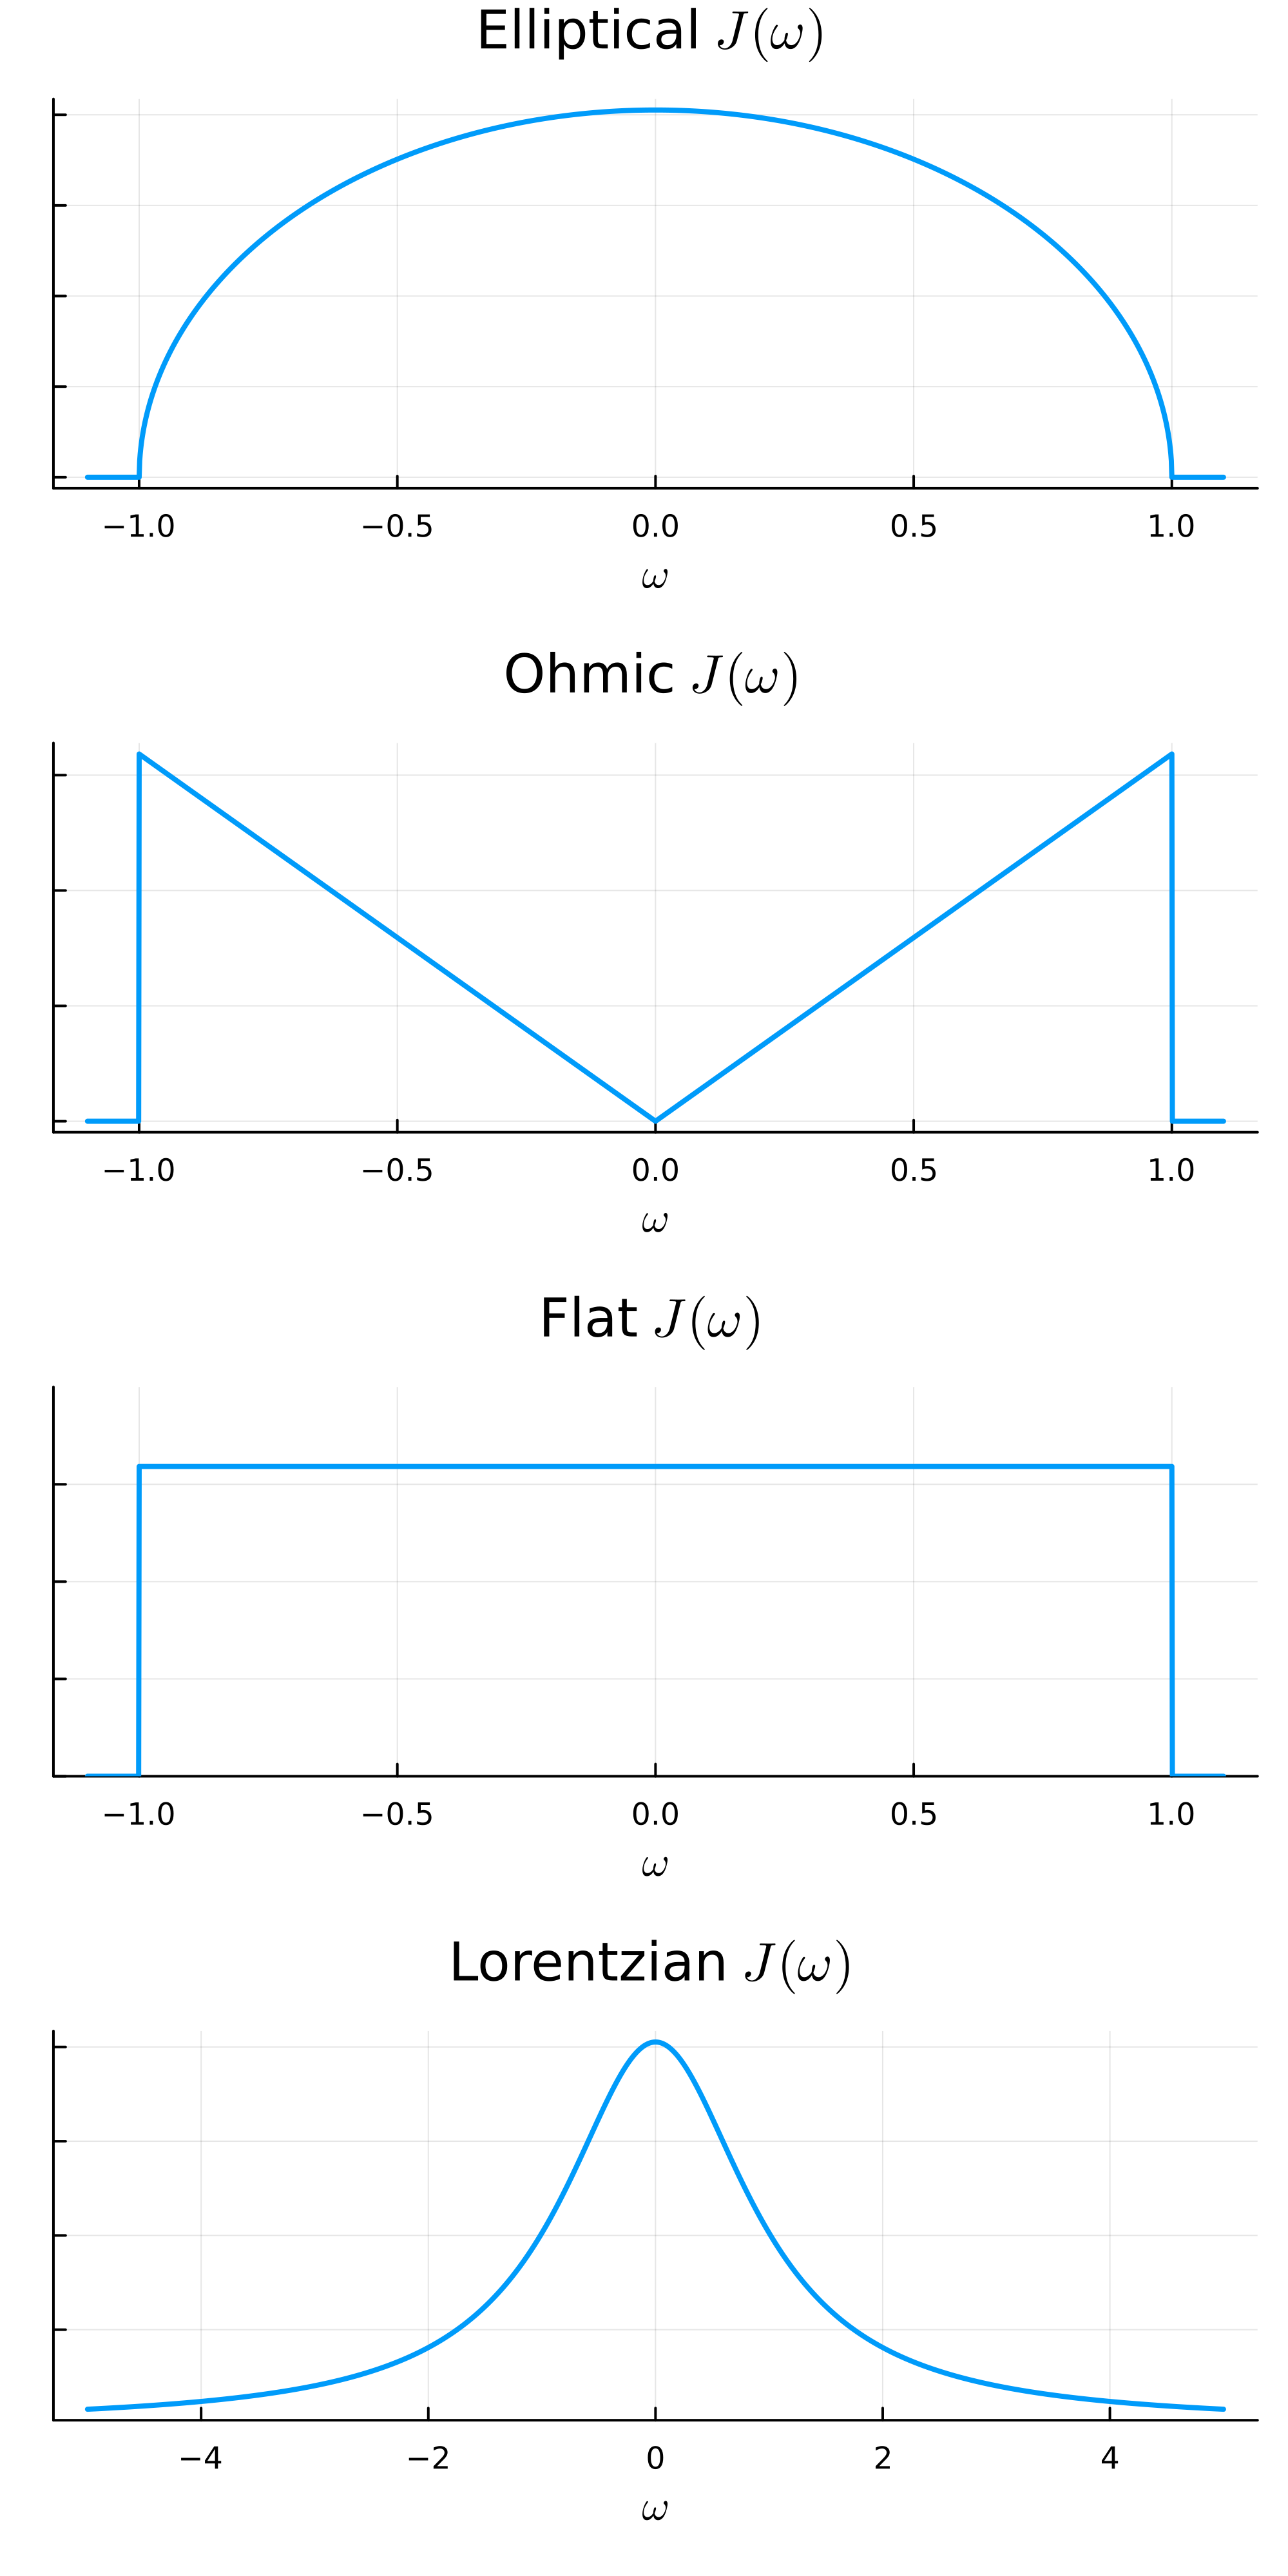

"/Users/ben/AgeingManyBodyQuantumSys/plot_images/specfuncs.png"

In [4]:
xvals=[x for x in -D-0.1:0.001:D+0.1]
J = create_spectral("elliptical", D, g)
p1 = plot(xvals, J, title="Elliptical \$J(\\omega)\$", xlabel="\$\\omega\$", lw=2, label="")

J = create_spectral("ohmic", D, g)
p2 = plot(xvals, J, title="Ohmic \$J(\\omega)\$", xlabel="\$\\omega\$", lw=2, label="")

J = create_spectral("flat", D, g)
p3 = plot(xvals, J, title="Flat \$J(\\omega)\$", xlabel="\$\\omega\$", lw=2, label="", ylims=(0.0,0.2))

J = create_spectral("lorentzian", D, g)
p4 = plot([-5D:0.01:5D], J, title="Lorentzian \$J(\\omega)\$", xlabel="\$\\omega\$", lw=2, label="")

p = plot(p1, p2, p3, p4; layout=(4,1), yformatter=_->"", size=(500,1000), dpi=400)
display(p)
savefig(p, "/Users/ben/AgeingManyBodyQuantumSys/plot_images/specfuncs.png")



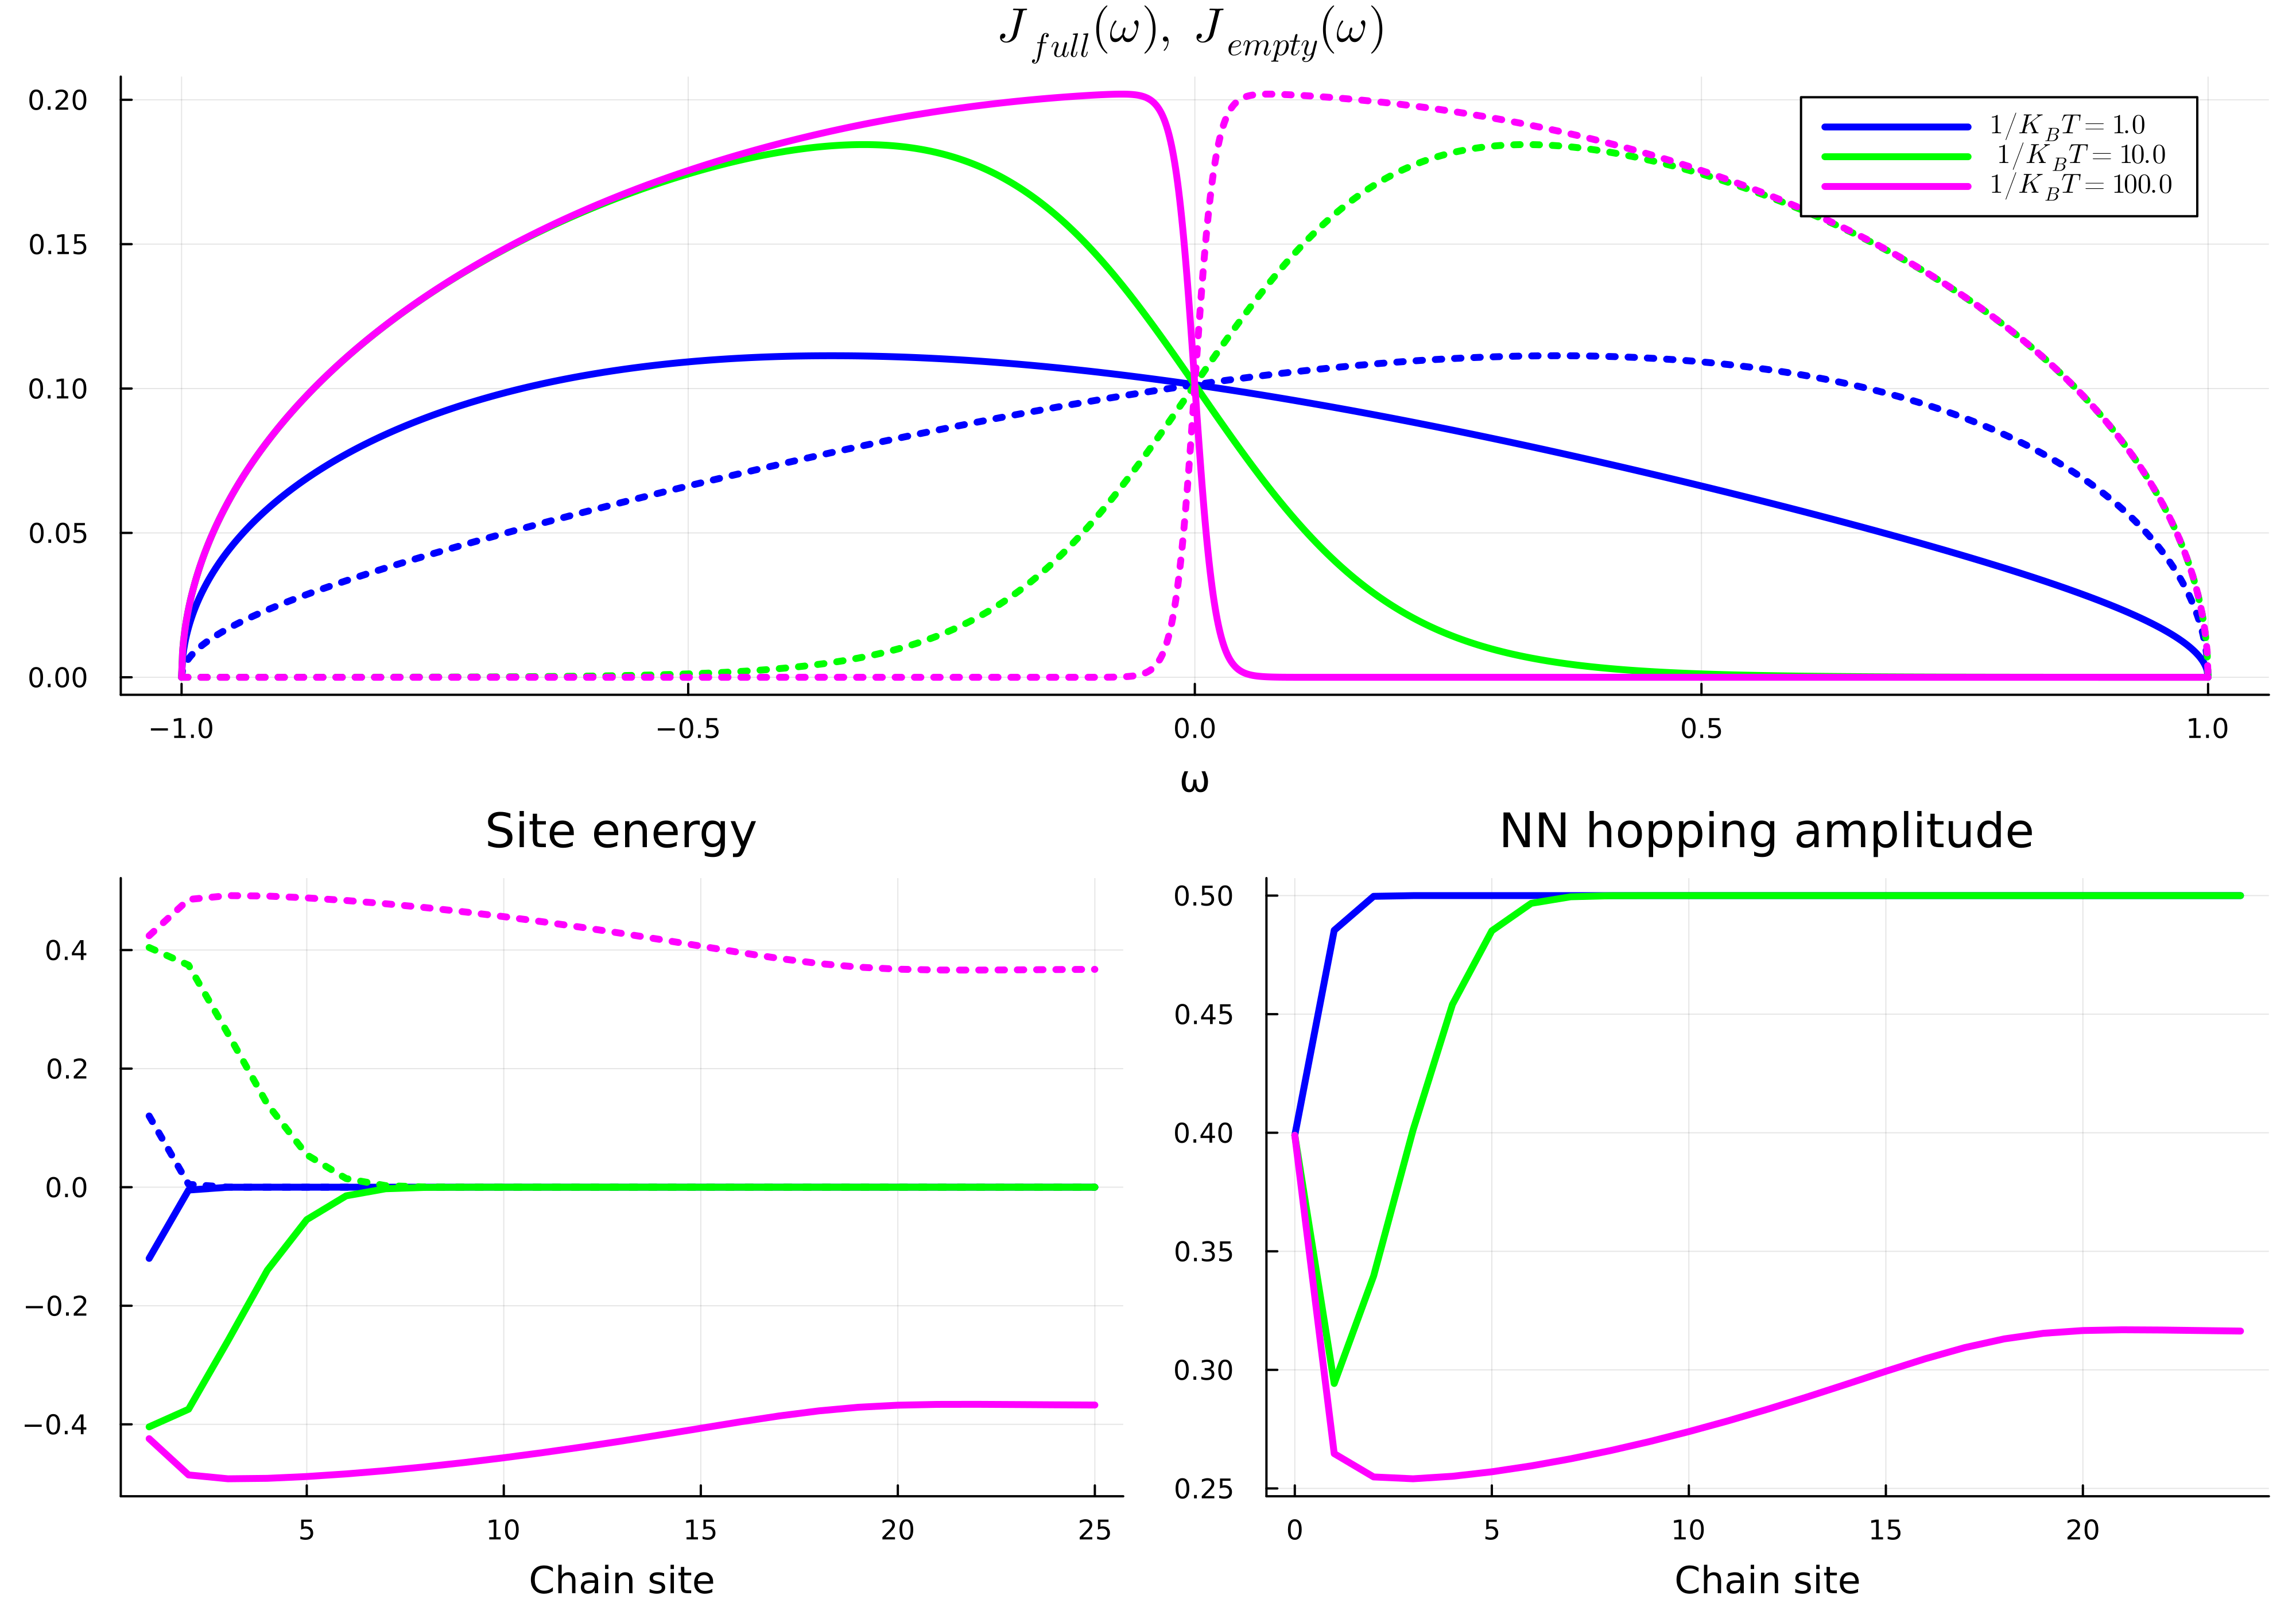

"/Users/ben/AgeingManyBodyQuantumSys/plot_images/thermofuncs.png"

In [5]:
N=25

beta = 1.0
J = create_spectral("elliptical", D, g)
J1, J2 = thermofield_transform(J, beta, mu)
E1, t1 = chain_map(J1, N, D)
E2, t2 = chain_map(J2, N, D)

p1 = plot([x for x in -D:0.001:D], J1, c=:blue, lw=3, xlabel="ω", title="\$ J_{full}(\\omega),~J_{empty}(\\omega)\$", label="\$ 1/K_B T  = $beta\$")
plot!(p1, [x for x in -D:0.001:D], J2, linestyle=:dot, c=:blue, lw=3, label="")
p2 = plot(1:N, E1, xlabel="Chain site", title="Site energy", label="", lw=3, c=:blue)
plot!(p2, 1:N, E2, label="", linestyle=:dot, lw=3, c=:blue)
p3 = plot(0:N-1, t1, xlabel="Chain site", title="NN hopping amplitude", label="", lw=3, c=:blue)

beta = 10.0
J = create_spectral("elliptical", D, g)
J1, J2 = thermofield_transform(J, beta, mu)
E1, t1 = chain_map(J1, N, D)
E2, t2 = chain_map(J2, N, D)

plot!(p1, [x for x in -D:0.001:D], J1, c=:lime, lw=3, label="\$\\ 1/K_B T  = $beta\$")
plot!(p1, [x for x in -D:0.001:D], J2, linestyle=:dot, c=:lime, lw=3, label="")
plot!(p2, 1:N, E1, label="", lw=3, c=:lime)
plot!(p2, 1:N, E2, label="", linestyle=:dot, lw=3, c=:lime)
plot!(p3, 0:N-1, t1, label="", lw=3, c=:lime)

beta = 100.0
J = create_spectral("elliptical", D, g)
J1, J2 = thermofield_transform(J, beta, mu)
E1, t1 = chain_map(J1, N, D)
E2, t2 = chain_map(J2, N, D)

plot!(p1, [x for x in -D:0.001:D], J1, c=:magenta, lw=3, label="\$ 1/K_B T = $beta\$")
plot!(p1, [x for x in -D:0.001:D], J2, linestyle=:dot, c=:magenta, lw=3, label="", dpi=500)
plot!(p2, 1:N, E1, label="", lw=3, c=:magenta)
plot!(p2, 1:N, E2, label="", linestyle=:dot, lw=3, c=:magenta)
plot!(p3, 0:N-1, t1, label="", lw=3, c=:magenta)

l = @layout [a; b c]

p = plot(p1, p2, p3; layout=l, size=(1000,700), dpi=400)

display(p)
savefig(p, "/Users/ben/AgeingManyBodyQuantumSys/plot_images/thermofuncs.png")



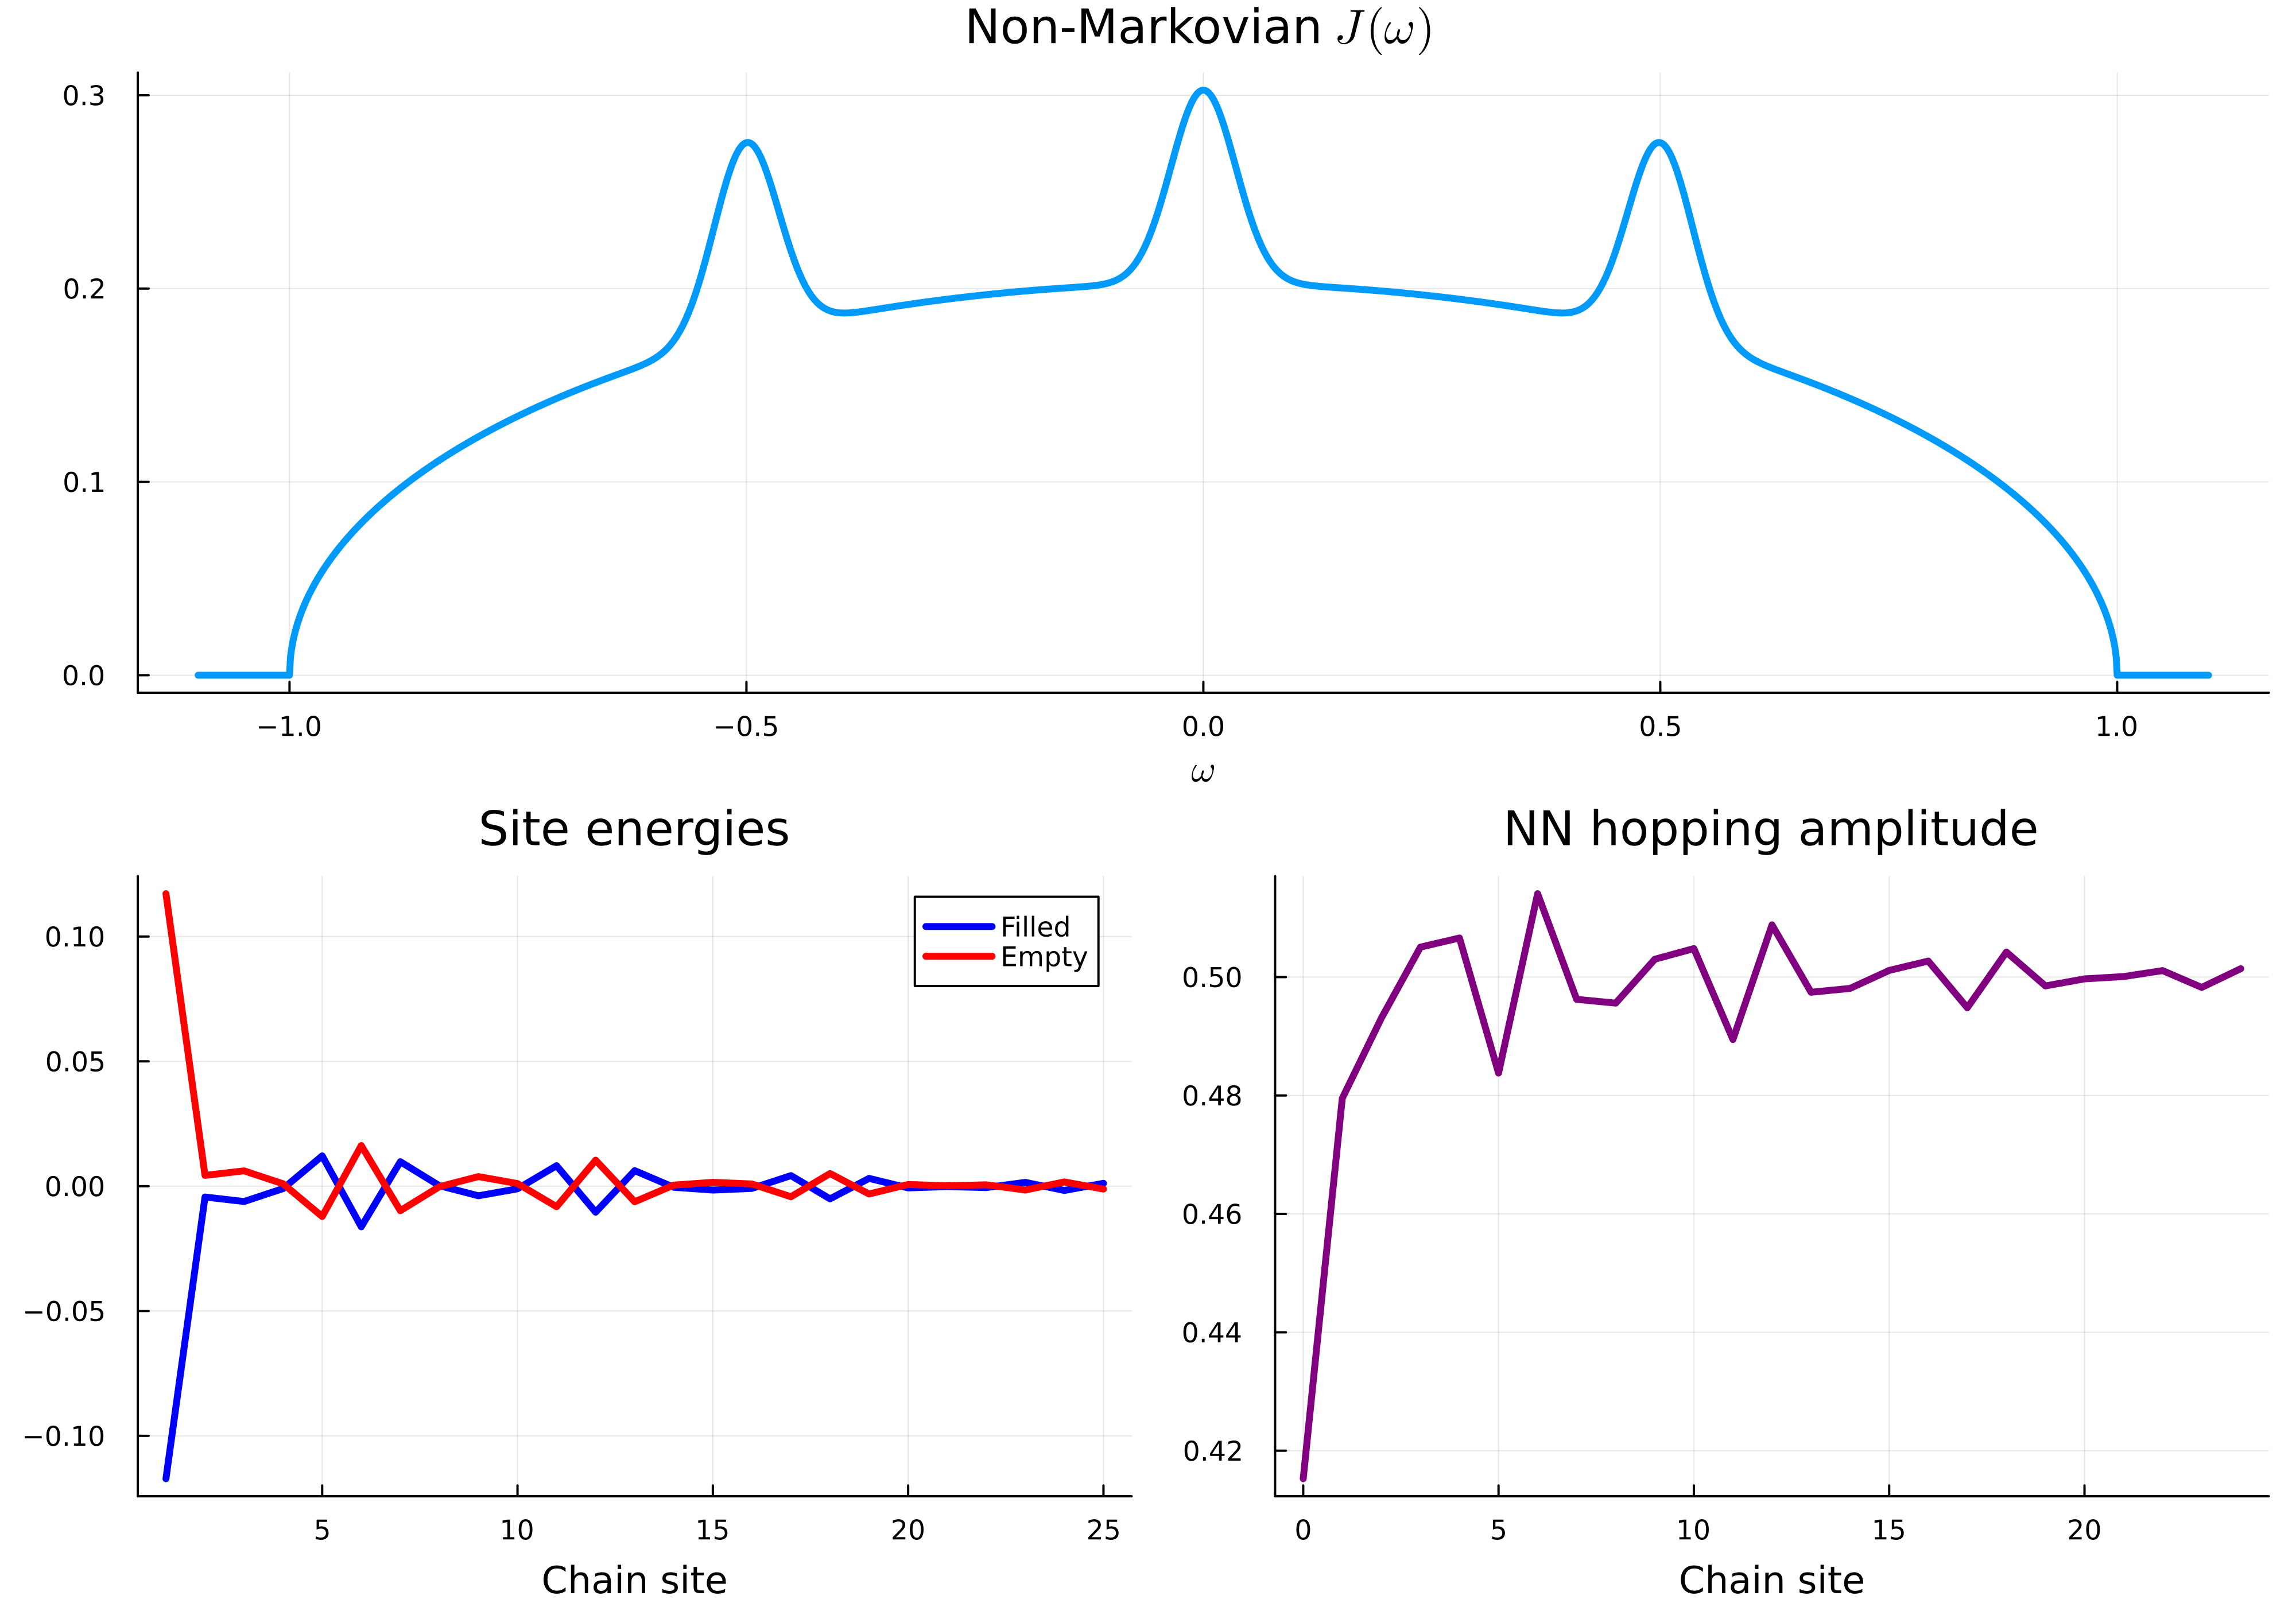

"/Users/ben/AgeingManyBodyQuantumSys/plot_images/NMcoeffs.png"

In [6]:
D=1.0
g=1.0
beta = 1.0
mu = 0.0

xvals=[-D-0.1:0.001:D+0.1]

N=25

J = create_spectral("elliptical",D,g)
params = (0.0, 0.05D, 0.1g)
Jmod1 = modify_spectral(J, "gaussian", params, D, g)
params = (-0.5, 0.05D, 0.1g)
Jmod2 = modify_spectral(Jmod1, "gaussian", params, D, g)
params = (0.5, 0.05D, 0.1g)
Jmod3 = modify_spectral(Jmod2, "gaussian", params, D, g)

J1, J2 = thermofield_transform(Jmod3, beta, mu)


E1, h1 = chain_map(J1, N, D)
E2, h2 = chain_map(J2, N, D)

p3 = plot(xvals, Jmod3, xlabel="\$\\omega\$",title="Non-Markovian \$J(\\omega)\$", label="", lw=3)

p1 = plot(1:N, E1, xlabel="Chain site", title="Site energies", lw=3, c=:blue, label="Filled")
plot!(p1, 1:N, E2, lw=3, label="Empty", c=:red)

p2 = plot(0:N-1, h1, xlabel="Chain site", title="NN hopping amplitude", lw=3, c=:purple, label="")

l = @layout [a; b c]

p = plot(p3, p1, p2; layout=l, size=(1000,700), dpi=400)
display(p)
savefig(p, "/Users/ben/AgeingManyBodyQuantumSys/plot_images/NMcoeffs.png")



In [7]:
function trace_distance(rho1, rho2)
    return 0.5 * abs(rho1-rho2)
end

N = 50
dt=0.1
tmax = 100
sys=N+1

g=0.3
D=1.0
mu=0.0
Esys=0.0

mean = collect(-0.8:0.1:0.8)
amp = -0.1g
std = 0.05D

BLP1 = []
for m in mean
    J = create_spectral("elliptical", D, g)
    J = modify_spectral(J, "gaussian", (m,std,amp),g,D)
    J1, J2 = thermofield_transform(J, beta, mu)

    E1, h1 = chain_map(J1, N, D)
    E2, h2 = chain_map(J2, N, D)

    H = make_H_matrix(E1, E2, h1, h2, Esys, N, sys)
    C0_full = prepare_correlations(N,sys,1.0)
    C0_empty = prepare_correlations(N,sys,0.0)
    Cs_full = evolve_corrs(C0_full, H, dt, tmax, N)
    Cs_empty = evolve_corrs(C0_empty, H, dt, tmax, N)
    len = length(Cs_full)


    d2 = [trace_distance(real(Cs_full[t][N+1,N+1]), real(Cs_empty[t][N+1,N+1])) for t in 1:len]
    Df = d2[2:end]
    Di = d2[1:end-1]
    dD_dt = real.(Df-Di)
    Nphi = sum(dD_dt[dD_dt .>= 0.0])
    push!(BLP1, Nphi)
end

amp=0.1g
BLP2 = []
for m in mean
    J = create_spectral("elliptical", D, g)
    J = modify_spectral(J, "gaussian", (m,std,amp),g,D)
    J1, J2 = thermofield_transform(J, beta, mu)

    E1, h1 = chain_map(J1, N, D)
    E2, h2 = chain_map(J2, N, D)

    H = make_H_matrix(E1, E2, h1, h2, Esys, N, sys)
    C0_full = prepare_correlations(N,sys,1.0)
    C0_empty = prepare_correlations(N,sys,0.0)
    Cs_full = evolve_corrs(C0_full, H, dt, tmax, N)
    Cs_empty = evolve_corrs(C0_empty, H, dt, tmax, N)
    len = length(Cs_full)


    d2 = [trace_distance(real(Cs_full[t][N+1,N+1]), real(Cs_empty[t][N+1,N+1])) for t in 1:len]
    Df = d2[2:end]
    Di = d2[1:end-1]
    dD_dt = real.(Df-Di)
    Nphi = sum(dD_dt[dD_dt .>= 0.0])
    push!(BLP2, Nphi)
end

In [8]:
p = plot(mean, BLP1, xlabel="Gaussian mean", ylabel="BLP Measure", label="Negative Gaussian", lw=3, c=:red, title="Gaussian perturbations of Elliptical \$J(\\omega)\$")
plot!(p, mean, BLP2, label="Positive Gaussian", lw=3, c=:blue, dpi=400)

savefig(p, "/Users/ben/AgeingManyBodyQuantumSys/plot_images/gaussian.png")


"/Users/ben/AgeingManyBodyQuantumSys/plot_images/gaussian.png"